<a href="https://colab.research.google.com/github/bintualkassoum/sentiment_analysis/blob/main/MMAI_5400_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 5400 Assignment 2 -- Sentiment Classification 💬
## Project Information
For this assignment you will build a sentiment classifier to classify restaurant reviews.

## Submission
This assignment should be submitted as Python 3 code and uploaded to Canvas. The submission should be a single PY file,
and not a Jupyter Notebook. The due date is on June 20 at 8:30 am.
The code will be tested and should produce the output specified below.

## Data
You will be using a the file reviews.csv that contains close to 2000 reviews. Values in reviews.csv are tab separated instead
of comma separated as if often the case in CSV files. To read reviews.csv with pandas it might be good to specify tab as the
delimiter, as follows:
```
data = pd.read_csv('reviews.csv', delimiter='\t')
```

# Install Packages and Dependencies 📚

In [ ]:
# Install the PyDrive wrapper & import libraries
# This only needs to be done once per notebook
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# This only needs to be done once per notebook
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
%matplotlib inline

#Import Packages
from zipfile import ZipFile
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import re
from string import punctuation
import matplotlib.pylab 
from matplotlib.pyplot import cm
from collections import Counter
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
#Helper Functions
import sys
!{sys.executable} -m pip install dmba
from dmba import printTermDocumentMatrix, classificationSummary, liftChart
!pip install -U pip setuptools wheel 
!pip install -U spacy
!python -m spacy download en_core_web_sm

#scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

#nltk
!pip install stop-words
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Pre-Processing 🧪

## Load Data

In [ ]:
# Mount Google Drive 
from google.colab import drive 
drive.mount('/content/drive')
text = pd.read_csv('/content/drive/MyDrive/Grad School/MMAI Summer 2022/MMAI 5400 NLP/Assignment #2/reviews (2).csv', delimiter='\t')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Adjust Text Description Length 
pd.set_option('max_colwidth', 100)

In [ ]:
# Load Data 
print(text.columns)

print(text.describe)

Index(['Name', 'RatingValue', 'DatePublished', 'Review'], dtype='object')
<bound method NDFrame.describe of                        Name  RatingValue DatePublished  \
0              Playa Cabana            4    2020-02-26   
1              Playa Cabana            3    2019-08-04   
2              Playa Cabana            3    2019-08-24   
3              Playa Cabana            4    2019-06-06   
4              Playa Cabana            5    2020-05-25   
...                     ...          ...           ...   
1915  Greedy Duck & Noodles            2    2019-04-29   
1916  Greedy Duck & Noodles            5    2019-08-15   
1917  Greedy Duck & Noodles            5    2019-03-16   
1918  Greedy Duck & Noodles            4    2019-10-12   
1919  Greedy Duck & Noodles            5    2018-09-07   

                                                                                                   Review  
0     I was tasked with finding a spot for a group dinner of eight and landed on Playa 

## Visualize Review Score Distribution

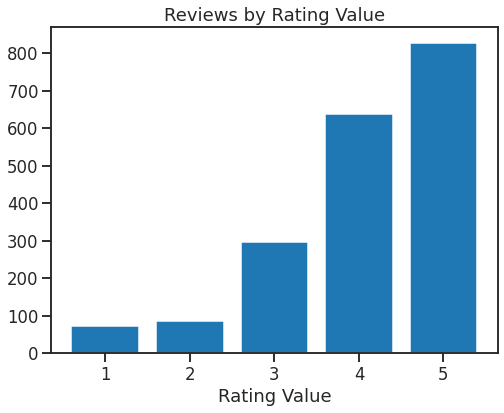

In [ ]:
# Visualize Review Score Distribution
%matplotlib inline
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,6), np.bincount(text['RatingValue'])[1:])
plt.title("Reviews by Rating Value")
plt.xlabel("Rating Value")
plt.show()

# Statistical Analysis 📈

In [ ]:
# Install Packages 
import spacy
!python -m spacy download en_core_web_lg # if not installed
nlp = spacy.load('en_core_web_lg') # about 850 MB
from spacy import displacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
np.random.seed(42)

def random_pooling(text, sample_len, classes = np.arange(1,6)):
  scores = [np.random.choice(text[text['RatingValue']==x].index, sample_len, replace =  True)
            for x in classes]
  
  return np.array(scores)

In [ ]:
ratings = random_pooling(text, 400)

example_reviews = text.head(0)
for i in range(5):
  example_reviews = pd.concat([example_reviews, text.iloc[ratings[i]][:5]])
  
example_reviews

,Name,RatingValue,DatePublished,Review
1528,98 Aroma,1,2019-12-10,"Inattentive staff, over cooked food. Noodle break right apart because it's so overdone."
421,Xola Mexican Food,1,2020-01-29,I came her few weeks ago. I straight up saw this lady (pretty sure the owner) handle cash/ scrat...
1895,Blooming Orchid,1,2019-11-01,"NEVER ORDER FROM THIS RESTAURANT! We order from them at least 10 times a week, from our staff to..."
1759,Dynasty Chinese Cuisine,1,2019-12-24,Worst experience I have ever had at a restaurant! \nThe service was so slow; we got our food aft...
588,Los Guaca-Moles,1,2018-09-23,"If you want to pay for a virgin margarita for a regular priced margarita, by all means come to t..."
1878,Lai Wah Heen,2,2019-07-11,"First of all, let's be clear. Growing up in Asia, I have tasted the best of the best! So I'm not..."
540,Mariachi’s Restaurant,2,2018-10-13,Went there on a Sat night at 6pm for dinner before a movie. \nOn the plus side the service was ...
283,El Charro,2,2020-04-18,"I added this to my list based on good Yelp reviews. We ordered a takeaway - burrito, quesadilla ..."
1043,Levetto,2,2018-11-22,Overrated non-authentic Italian food. Their location gives them business. \n\nMenu is interestin...
748,Enoteca Sociale,2,2019-07-27,I came here and had a short male server with a buzz cut and glasses that was very rude.


In [ ]:
"""
Count adjetive and adverb
Scale them to per 100 words
Return a list of lists by score group)
"""
def expressiveness(i):
  adj_adv = []
  tokens = []
  
  for sentence in text.iloc[ratings[i]]['Review']:
    doc = nlp(sentence)
    expr_count = 0
    for token in doc:
      if token.pos_=='ADJ' or token.pos_=='ADV':
        expr_count += 1
    # adjective and adverb per 100 words
    adj_adv.append(expr_count*100/len(doc))
    tokens.append(len(doc))
    
  return np.array(adj_adv), np.array(tokens)
  
%time expr_scores = [expressiveness(x) for x in range(5)]

CPU times: user 1min 12s, sys: 754 ms, total: 1min 13s
Wall time: 1min 24s


In [ ]:
# Average of Adjectives and Adverbs 
adj_adv_average = [round(adj_adv[0].mean(), 1) for adj_adv in expr_scores]
length_average = [round(adj_adv[1].mean(), 1) for adj_adv in expr_scores]

pd.DataFrame({'ADJ/ADV_per_100': adj_adv_average,
              'Sentence_Length': length_average}, index=np.arange(1,6))

,ADJ/ADV_per_100,Sentence_Length
1,14.5,174.2
2,15.6,165.3
3,15.8,181.2
4,16.6,166.8
5,16.3,136.2


**Observation #1:**  sentence length seems to vary across ratings, however, the reviews with a rating of 5 had shorter sentences lengths than reviews with rating between 1 and 4

**Observation #2:**  reviews with a rating of 1 didn't use as many adverbs and adjectives as other reviews, yet also had the high average sentence lengths on average - *long, less expressive sentences*

**Observation #3:**  conversely, reviews with a rating of 5 had had the highest average adverbs and adjectives used and had the shortest sentences - *short, more expressive sentences - *(i.e. "it was exceptionally great!!! absoluetly amazing!..) *

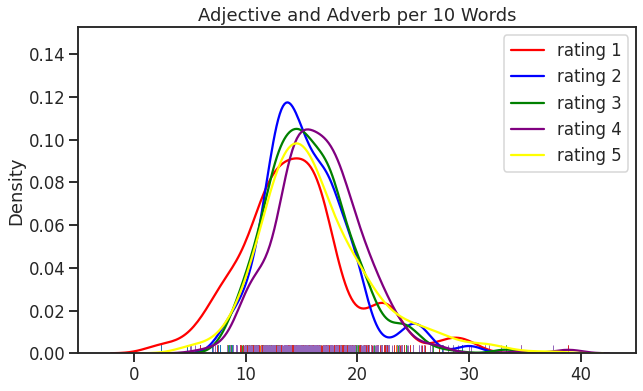

In [ ]:
# Visualize Adj/Adv Distribution
plt.figure(figsize=(10,6))

colors = ['red', 'blue', 'green', 'purple', 'yellow']
labels=['rating 1', 'rating 2', 'rating 3', 'rating 4', 'rating 5']
for i in range(5):
  sns.kdeplot(expr_scores[i][0], color=colors[i], label=labels[i])
  sns.rugplot(expr_scores[i][0])

plt.title("Adjective and Adverb per 10 Words")
plt.xlim(-5, 45)
plt.legend()
plt.show()

In [ ]:
# Shapiro Normality Test
import scipy.stats as stats

print("Shapiro's Normality Test\n")
for i in range(5):
  _, p = stats.shapiro(expr_scores[i][0])
  print("- Score {}'s P-value: {:.3f}".format(i+1, p))

Shapiro's Normality Test

- Score 1's P-value: 0.000
- Score 2's P-value: 0.000
- Score 3's P-value: 0.000
- Score 4's P-value: 0.000
- Score 5's P-value: 0.000


$$Shapiro's\ Test\ - \ H_0: The\ distribution\ is\ normal\\ vs.\ H_1: The\ distribution\ is\ not\ normal$$
<br>
The 5 groups all look like a symmetric bell shape, but we still want to make sure of normality by using *Shapiro's Test*. According to the test, they are not normal, letting us conduct a non-parametric test; *Kruskal-Wallis test*. As seen below, the test shows that only the score 1 is different from the rest in how many adjectives and adverbs are used. Indeed, the score 1 (red) on the plot is slightly on the left.

<br>
$$Kruskal\ Wallis\ Test\ - \ H_0: The\ groups\ are\ from\ the\ same\ populations\\ vs.\ H_1: At\ least\ one\ of\ the\ groups\ is\ from\ different\ population$$

**Source:** Kim, K (2019) Amazon Food Review NLP (Version 1.0) [[Source code]](https://github.com/Q-shick/amazon_food_review_nlp/blob/master/amazon_food_review_nlp.ipynb). https://github.com/Q-shick/amazon_food_review_nlp

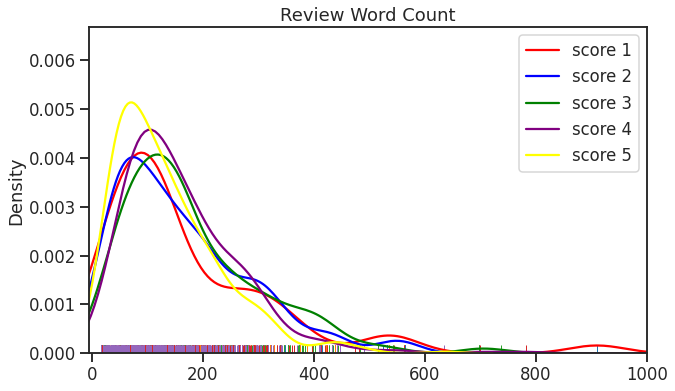

In [ ]:
# Visualize Word Count Distribution 
plt.figure(figsize=(10,6))

colors = ['red', 'blue', 'green', 'purple', 'yellow']
labels=['score 1', 'score 2', 'score 3', 'score 4', 'score 5']
for i in range(5):
  sns.kdeplot(expr_scores[i][1], color=colors[i], label=labels[i])
  sns.rugplot(expr_scores[i][1])

plt.title("Review Word Count")
plt.xlim(-5, 1000)
plt.legend()
plt.show()

# Topic Analysis 📑

In [ ]:
# Install Packages
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
text.columns

Index(['Name', 'RatingValue', 'DatePublished', 'Review'], dtype='object')

## Latent Dirichlet Allocation 

In [ ]:
# Latent Dirichlet Allocation 

def lda_extract(size, RatingValue, num_topic):
  indice = text[text['RatingValue']==RatingValue].index
  sentences = text.iloc[np.random.choice(indice, size, replace=True)]['Review']

  vectorizer = CountVectorizer(max_df=.95, min_df=10, stop_words='english')
  topic_sentences = vectorizer.fit_transform(sentences)

  LDA = LatentDirichletAllocation(n_components=num_topic)
  LDA.fit(topic_sentences)
  
  print("- Rating Value: ", RatingValue, " Topics")
  for i, topic in enumerate(LDA.components_):
    print(i+1, ":", [vectorizer.get_feature_names()[j] for j 
          in topic.argsort()[-10:]])
  print('\n')

In [ ]:
for i in np.arange(1,6):
  lda_extract(2000, i, 5)

All topics appear to be related to one another, including things like food, service, restaurant. 

# Sentiment Analysis 🙃

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sid = SentimentIntensityAnalyzer()

ratings = random_pooling(text, 400)
comp_ratings = [text.iloc[ratings[i]]['Review'].apply(lambda x:
               sid.polarity_scores(x)['compound']) for i in range(5)]

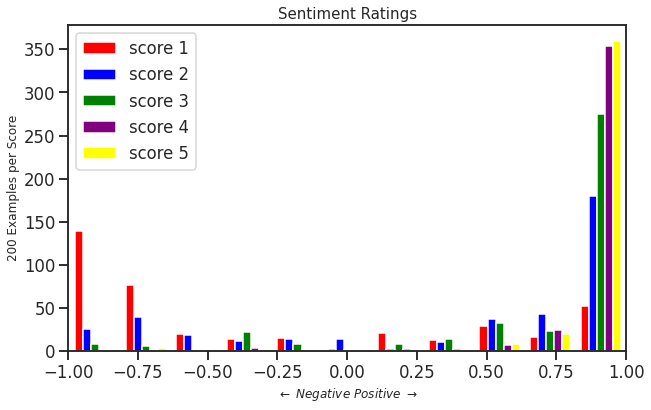

In [ ]:
colors = ['red', 'blue', 'green', 'purple', 'yellow']
labels=['score 1', 'score 2', 'score 3', 'score 4', 'score 5']

plt.figure(figsize=(10,6))
plt.hist(comp_ratings, bins=11, color=colors, label=labels)
plt.title("Sentiment Ratings", fontsize=15)
plt.xlabel(r"$\leftarrow\ Negative\ Positive\ \rightarrow$", fontsize=12)
plt.ylabel("200 Examples per Score", fontsize=12)
plt.xlim(-1,1)
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({'label': text.iloc[np.array(ratings).flatten()]['RatingValue'],
              'compound': np.array(comp_ratings).flatten()}).corr()

,label,compound
label,1.000000,0.602892
compound,0.602892,1.000000


This tells us that sentiments are 63% correlated with scores.

## Named Entity Recognition

In [ ]:
# Import Packages 
from collections import Counter

text['RatingValue'].value_counts()

min_len = len(text[text['RatingValue']==2])

print("Before undersampling: classes -", Counter(text['RatingValue']))
undersampling_idx = random_pooling(text, min_len)
text = text.iloc[np.array(undersampling_idx).flatten()]
text.reset_index(drop=True, inplace=True)
print("After undersampling: classes -", Counter(text['RatingValue']))

Before undersampling: classes - Counter({5: 828, 4: 637, 3: 297, 2: 86, 1: 72})
After undersampling: classes - Counter({1: 86, 2: 86, 3: 86, 4: 86, 5: 86})


In [ ]:
rand_idx = np.random.choice(text.index, 10)
entities_10_sentences = nlp(' '.join(text.iloc[rand_idx]['Review']))
displacy.render(entities_10_sentences, style='ent', jupyter=True)

In [ ]:
rand_idx = np.random.choice(text.index, 100)
entities_100_sentences = nlp(' '.join(text.iloc[rand_idx]['Review']))
labels = [x.label_ for x in entities_100_sentences.ents]

print("Named Entities")
pprint(Counter(labels))

# Organize Train and Test Sets 🧹 

In [ ]:
# Create Sentiment Bin 
# Using the right= argument to modify binning behavior

df['Sentiments'] = pd.cut(
    text['RatingValue'], 
    [1, 2, 3, 6], 
    labels=['0', '1', '2'],
    right=False
)

sentiments_df = pd.DataFrame(data = df['Sentiments'])
sentiments_df.rename(columns={'RatingValue': 'Sentiments'}, inplace=True)

print(sentiments_df.describe)

In [ ]:
text_df = pd.DataFrame(data = text['Review'])
text_df

In [ ]:
# Clean Data 

reviews_df = pd.concat([sentiments_df, text_df], axis = 1)
print(reviews_df)

In [ ]:
reviews_df.shape

# Text Pre-Processing 💻

In [ ]:
# Text Pre-Processing - Tokenize Words
reviews_df['Review'] = reviews_df['Review'].apply(str)

corpus = " ".join(reviews_df['Review'].tolist())
tokens = word_tokenize(corpus)

# Get Speech Tags
answer = nltk.pos_tag(tokens)
answer_pos = [a[1] for a in answer]

# Print Value Counts for Speech Tags 
all_pos = pd.Series(answer_pos)
all_pos.value_counts().head()

In [ ]:
# get the top words
token_corpus = nltk.word_tokenize(corpus)
freq_dist = nltk.FreqDist(token_corpus)

top_words = []
for key, value in freq_dist.items():
    top_words.append((key, value))

# sort the list by the top frequencies
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

# keep top 100 words only
top_words = top_words[:10]

# Keep the frequencies only from the top word series
top_word_series = pd.Series([w for (v,w) in top_words])
top_word_series[:5]

# get actual ranks of these words - wherever we see same frequencies, we give same rank
word_ranks = top_word_series.rank(method = 'min', ascending = False)

top_words

In [ ]:
# Check for Null Values 
reviews_df.isnull().sum()

Sentiments    0
Review        0
dtype: int64

In [ ]:
# Split Test and Train Sets 
X = reviews_df['Review']
y = reviews_df['Sentiments']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2
)

print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(344,)
(86,)
(344,)
(86,)


In [ ]:
# Save Results 
%%time

def remove_ner(sent):
  doc = nlp(sent)
  ner_idx = [(ent.start_char, ent.end_char) for ent in doc.ents]

  if ner_idx: # if not empty
    ner_removed = ""
    ner_len = len(ner_idx)-1
    
    ner_removed += sent[:ner_idx[0][0]]
    for i in range(ner_len):
      ner_removed += sent[ner_idx[i][1]+1 : ner_idx[i+1][0]]
    ner_removed += sent[ner_idx[ner_len][1]+1:]
    
    return ner_removed
    
  else:
    return sent
  
reviews_df['Review'] = reviews_df['Review'].apply(lambda x: remove_ner(x))

CPU times: user 15.1 s, sys: 158 ms, total: 15.3 s
Wall time: 16.4 s


# Model Building 🛠

In [ ]:
from pathlib import Path  
train_data = pd.DataFrame(data = [X_train, y_train])
filepath = Path('/content/drive/MyDrive/Grad School/MMAI Summer 2022/MMAI 5400 NLP/Assignment #2/train_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
train_data.to_csv(filepath) 

test_data = pd.DataFrame(data = [X_test, y_test])
filepath = Path('/content/drive/MyDrive/Grad School/MMAI Summer 2022/MMAI 5400 NLP/Assignment #2/test_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
test_data.to_csv(filepath) 

In [ ]:
# Download the cleaned file
train_df = pd.read_csv('/content/drive/MyDrive/Grad School/MMAI Summer 2022/MMAI 5400 NLP/Assignment #2/train_data.csv')
train_df = train_df.set_index('Unnamed: 0').T
train_df

test_df = pd.read_csv('/content/drive/MyDrive/Grad School/MMAI Summer 2022/MMAI 5400 NLP/Assignment #2/test_data.csv')
test_df = test_df.set_index('Unnamed: 0').T
test_df


In [ ]:
%%time 

vectorizer = TfidfVectorizer().fit(X_train)

X_train_lr = vectorizer.transform(X_train)
X_test_lr = vectorizer.transform(X_test)

words_df = pd.DataFrame(X_test_lr.toarray(), columns=vectorizer.get_feature_names())

print(words_df.head())

print("Vectorized Words:", X_train_lr.shape[1])

# Model Evaluation 🤨

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [ ]:
%%time
# Create and train a logistic regression
lr = LogisticRegression(C=1e9, solver='lbfgs')
lr.fit(X_train_lr, y_train)
lr_pred = lr.predict(X_test_lr)

CPU times: user 178 ms, sys: 244 ms, total: 422 ms
Wall time: 315 ms


In [ ]:
%%time
# Create and train a random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train_lr, y_train)
rf_pred = lr.predict(X_test_lr)

CPU times: user 427 ms, sys: 2.72 ms, total: 430 ms
Wall time: 511 ms


In [ ]:
%%time
# Create and train a linear support vector classifier (LinearSVC)
svc = LinearSVC()
svc.fit(X_train_lr, y_train)
svc_pred = svc.predict(X_test_lr)

CPU times: user 16.9 ms, sys: 3.96 ms, total: 20.9 ms
Wall time: 36.9 ms


In [ ]:
%%time
# Create and train a multinomial naive bayes classifier (MultinomialNB)
nb = MultinomialNB()
nb.fit(X_train_lr, y_train)
nb_pred = nb.predict(X_test_lr)

CPU times: user 5.45 ms, sys: 0 ns, total: 5.45 ms
Wall time: 9.97 ms


In [ ]:
# LR Model Results 
%%time
from sklearn.metrics import confusion_matrix

lr = LogisticRegression().fit(X_train_lr, y_train)
pred = lr.predict(X_test_lr)

print("Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred))
print('\n')
print(metrics.classification_report(y_test, pred))
print("Accuracy:", round(metrics.accuracy_score(y_test, pred), 2))
print('\n')

# References 
Kim, K (2019) Amazon Food Review NLP (Version 1.0) [[Source code]](https://github.com/Q-shick/amazon_food_review_nlp/blob/master/amazon_food_review_nlp.ipynb). https://github.com/Q-shick/amazon_food_review_nlp